# Spatial Plotting

**Author**: Clarence Mah | **Last Updated**: {sub-ref}`today`

We will demonstrate spatial visualization in `bento-tools` for exploring subcellular biology.

## A Brief Overview

In `bento-tools` we provide a high-level interface based on [matplotlib](https://matplotlib.org/) for plotting spatial transcriptomics formatted as an `AnnData` object. [See more details about the data structure here.](../howitworks.md) Data is represented as points and shapes, corresponding to molecules and segmentation masks. We closely mirror the [seaborn](http://seaborn.pydata.org/) package for mapping data semantics, while replicating some [geopandas](https://geopandas.org/en/stable/) plotting functionality with styles more suitable for visualizing subcellular data. For spatial visualization at the tissue level (i.e. plotting cell coordinates instead of cell boundaries) we recommend using [squidpy](https://squidpy.readthedocs.io/en/stable/) and [scanpy](https://scanpy.readthedocs.io/en/stable/index.html) instead.

```{note}
In general, plotting in `bento-tools` assumes datasets will have data stored from multiple fields of view (fov), which must be encoded in `adata.obs["batch"]`. The plotting functions plot a single fov at a time, which can be set with the `batch` parameter; if unspecified, the default is inferred from the first cell in `adata`.

If available, cell and nuclear shapes are plotted by default. Plot more shape layers by passing their names in a list to the `shapes` parameter.
```


## Load Libraries and Data


In [1]:
import bento as bt
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
sdata = bt.ds.sample_data()
sdata

  0%|          | 0/3 [00:00<?, ?it/s]

SpatialData object with:
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 7) (2D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (14, 3) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (12, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 14 × 135
    obs: 'cell_boundaries', 'region'
    uns: 'spatialdata_attrs': AnnData (14, 135)
with coordinate systems:
▸ 'global', with elements:
        transcripts (Points), cell_boundaries (Shapes), nucleus_boundaries (Shapes)

## Plotting points

Let's plot the points (RNA) as a scatterplot in 2D. This is a lightweight wrapper around [sns.scatterplot](https://seaborn.pydata.org/generated/seaborn.scatterplot.html). Refer to the seaborn documentation for more details.


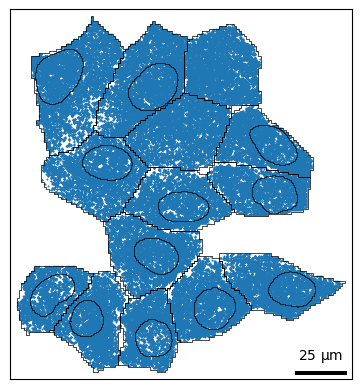

In [3]:
bt.pl.points(sdata)

You can use `hue` to color transcripts by their gene identity. In this case there are >9000 genes, so it isn't very informative; you can also hide the legend with `legend=False`.


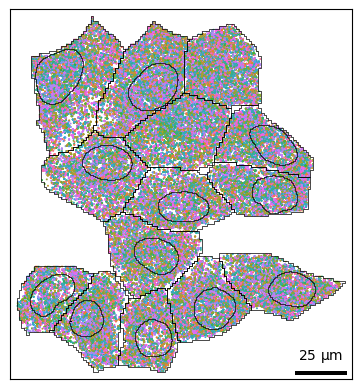

In [4]:
bt.pl.points(sdata, hue="feature_name", legend=False)

If you have certain genes of interest, you can slice the `adata` object for that subset.


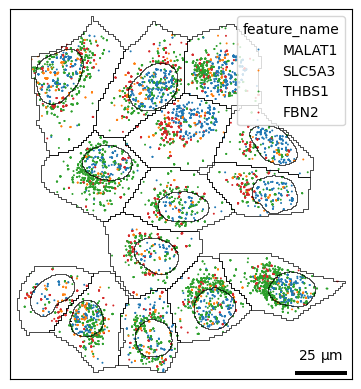

In [5]:
genes = ["MALAT1", "SLC5A3", "THBS1", "FBN2"]
bt.pl.points(sdata, hue="feature_name", hue_order=genes)

## Plotting distributions

Often it may be more useful to look at how molecules are distributed rather than individual points. The `density()` function wraps `sns.histplot` and `sns.kdeplot`, which is specified with `kind='hist'` and `kind='kde'` respectively.

Plot 2D histogram of points:


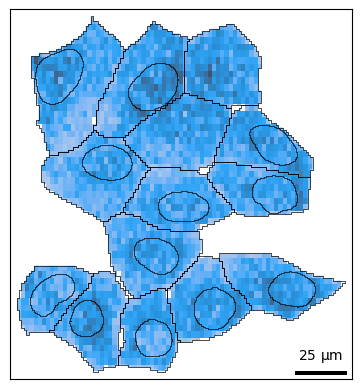

In [6]:
bt.pl.density(sdata)

Plot 2D kernel density estimate of points:

```{note}
Density plots are not recommended for a large number of points; plotting will be extremely slow.
```


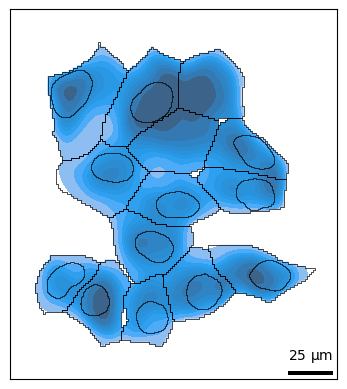

In [7]:
bt.pl.density(sdata, kind="kde")

## Plotting shapes

For finer control over plotting shapes, you can use `bt.pl.shapes()`. Similar to above, cells and nuclei are shown by default. This function wraps the `geopandas` function `GeoDataFrame.plot()`.


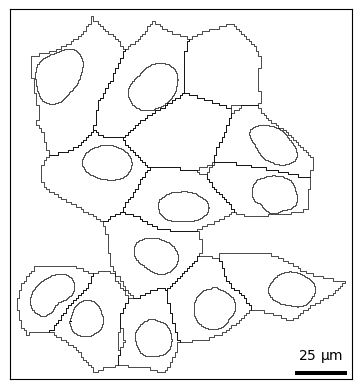

In [8]:
bt.pl.shapes(sdata)

For convenience, `shapes()` provides two coloring styles, `color_style='outline'` (default) and `color_style='fill'`.


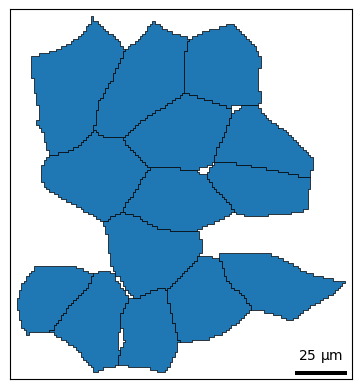

In [9]:
bt.pl.shapes(sdata, color_style="fill")

You can use the `hue` parameter to color shapes by group e.g. cell, cell type, phenotype, etc.


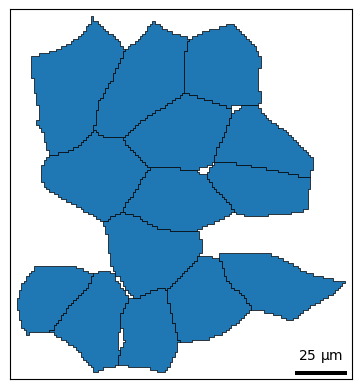

In [10]:
bt.pl.shapes(sdata, hue="cell", color_style="fill")

You can also layer shapes on top of each other in the same plot. This allows you to style shapes differently; for example we can highlight the nucleus with color and the cell membrane with a dashed line.


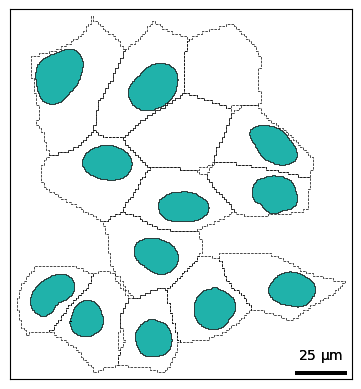

In [11]:
fig, ax = plt.subplots()
bt.pl.shapes(sdata, shapes="cell_boundaries", linestyle="--", ax=ax)
bt.pl.shapes(
    sdata,
    shapes="nucleus_boundaries",
    edgecolor="black",
    facecolor="lightseagreen",
    ax=ax,
)

## Figure aesthetics

To declutter unnecessary plot elements, you can use these convenient parameters:

- `axis_visible`: show/hide axis labels and ticks
- `frame_visible`: show/hide spines
- `square`: makes the plot square, useful for lining up multiple subplots
- `title`: defaults to the `batch` name, override with your own title

For example, to make a square plot with axis labels and spines:

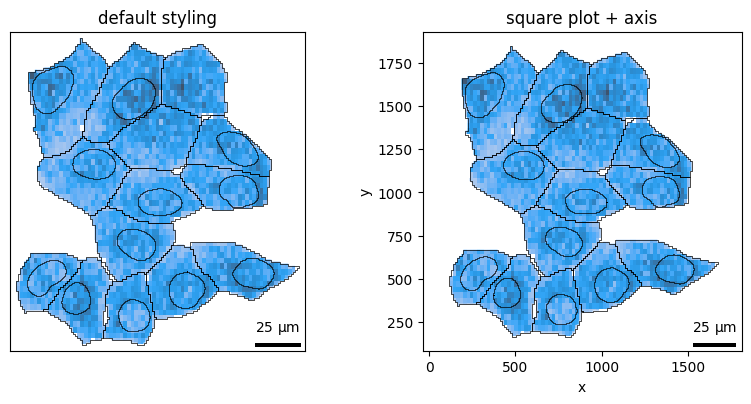

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

bt.pl.density(sdata, ax=axes[0], title="default styling")

bt.pl.density(
    sdata,
    ax=axes[1],
    axis_visible=True,
    frame_visible=True,
    square=True,
    title="square plot + axis",
)
plt.tight_layout()

You can even plot cell/nuclei in dark mode:

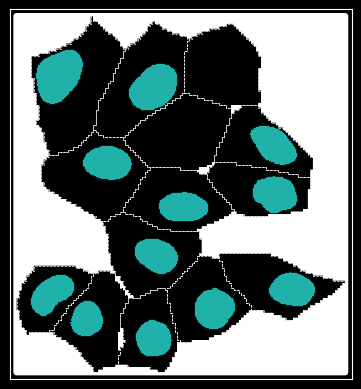

In [13]:
with mpl.style.context("dark_background"):
    fig, ax = plt.subplots()
    bt.pl.shapes(sdata, shapes="cell_boundaries", linestyle="--", ax=ax)
    bt.pl.shapes(
        sdata,
        shapes="nucleus_boundaries",
        edgecolor="black",
        facecolor="lightseagreen",
        ax=ax,
    )

## Building subplots

Since all plotting functions operate on `matplotlib.Axes` objects, not only can you build plots layer by layer, you can create multiple subplots.

```{note}
Subsetting SpatialData objects is still a tedious process, and we plan to implement a more user-friendly interface in the future.
```

You can tile across individual cells:


In [14]:
import spatialdata as sd

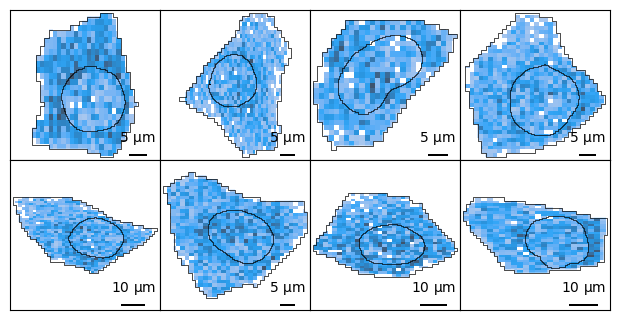

In [15]:
cells = sdata["cell_boundaries"].index.tolist()  # get some cells
ncells = len(cells)

ncols = 4
nrows = 2
ax_height = 1.5
fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * ax_height, nrows * ax_height)
)  # instantiate

for c, ax in zip(cells, axes.flat):
    cell_bounds = list(sdata["cell_boundaries"].loc[c].geometry.bounds)
    cell_sdata = sd.bounding_box_query(
        sdata,
        axes=["x", "y"],
        min_coordinate=cell_bounds[:2],
        max_coordinate=cell_bounds[2:],
        target_coordinate_system="global",
    )

    bt.pl.density(
        cell_sdata,
        ax=ax,
        square=True,
        title="",
    )

plt.subplots_adjust(wspace=0, hspace=0, bottom=0, top=1, left=0, right=1)